<a href="https://colab.research.google.com/github/hanhanwu/Hanhan_COLAB_Experiemnts/blob/master/Try_DeepWalk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


I got generated the graph by using `seealsology`

* https://densitydesign.github.io/strumentalia-seealsology/
* It does web crawling for any wiki-page you typed in and creates a graph for you to download.
* I used "environment protection" and "global warming" 2 wiki pages

In [0]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

## Extract RandomWalk Sequeces from the Graph

In [3]:
graph_df = pd.read_csv("environment_wiki_graph.tsv", sep = "\t")
graph_df.head()

,source,target,depth
0,environmental protection,biodiversity,1
1,environmental protection,carbon offset,1
2,environmental protection,citizen science,1
3,environmental protection,conservation biology,1
4,environmental protection,conservation movement,1


In [4]:
graph_df['source'].value_counts()

sustainable development                 38
environmentalism                        38
sustainability                          34
natural resource management             34
environmental movement                  31
ecology movement                        31
natural capital                         27
environmental protection                25
conservation movement                   24
earth day                               23
environmental racism                    23
conservation biology                    20
anthropocene                            19
carbon offset                           19
participation (decision making)         13
citizen science                         13
holocene extinction                     13
public information and participation    13
green solutions                         13
planetary boundaries                    13
renewable resource                      11
biodiversity                             9
environmental governance                 9
global cool

In [5]:
# construct the graph
G = nx.from_pandas_edgelist(graph_df, "source", "target", 
                            edge_attr=True, create_using=nx.Graph())
G

In [6]:
# The number of nodes
len(G)

367

In [0]:
def random_walk(source_node, sequence_len):
  """
  For a souce node, get its neighbours that not in the random-walk sequence,
  randomly select a neighbour as the next source node,
  repeat until reaches to the max length or there is no node to choose.

  NOTE: No need to set seed for random, cuz we want each time to generate
        a different sequence when call this function.
  """
  random_walk_sequence = [source_node]

  for i in range(sequence_len - 1):
    target_nodes = list(G.neighbors(source_node))
    target_nodes = list(set(target_nodes) - set(random_walk_sequence))
    if len(target_nodes) == 0:
      break

    selected_node = random.choice(target_nodes)
    random_walk_sequence.append(selected_node)
    source_node = selected_node

  return random_walk_sequence

In [8]:
random_walk('sustainable development', 7)

['sustainable development',
 'ecological footprint',
 'natural capital',
 'ecological economics',
 'environmental movement',
 'timeline of environmental events',
 'ecology movement']

In [9]:
# get random_walk sequences for all the nodes
all_nodes = list(G.nodes)

random_walks = []
for n in tqdm(all_nodes):  # tqdm is to show the progress
  for i in range(4):
    random_walks.append(random_walk(n, 10))

print(len(random_walks))

100%|██████████| 367/367 [00:00<00:00, 13871.15it/s]

1468


In [10]:
for seq in random_walks[4:10]:
  print(seq)

['biodiversity', 'environmental protection', 'renewable resource', 'scarcity']
['biodiversity', 'natural resource management', 'environmentalism', 'religion and environmentalism']
['biodiversity', 'defaunation', 'anthropocene', 'anthropocentrism', 'holocene extinction', 'extinction rebellion']
['biodiversity', 'deforestation and climate change']
['carbon offset', 'gold standard (carbon offset standard)']
['carbon offset', 'environmental protection', 'renewable resource', 'exploitation of natural resources']


## Train Skip-Gram

* [Relevant Params for Word2Vec here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec)
* Each sequence has been converted as a vector

In [0]:
from gensim.models import Word2Vec

# maximum distance between current node to predicted node is 3
# negative sampling, random 10 noise words
# learning rate linearly decrease from alpha to min alpha
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, 
                 alpha=0.03, min_alpha=0.0007, 
                 seed = 10)

model.build_vocab(random_walks, progress_per=2) # process 2 nodes before updating progress

In [12]:
# By default in Word2Vec, each node is represented by a fixed length 100
model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)

(86765, 128940)

In [13]:
import warnings
warnings.filterwarnings('ignore')

# with trained model, find similar sequence
## But input here has to be in the vocabulary
model.similar_by_word('earth day')

[('carbon footprint', 0.9416614174842834),
 ('capacity factor', 0.936726450920105),
 ('under2 coalition', 0.9267891049385071),
 ("expo '74", 0.9267367124557495),
 ('earth charter', 0.9129364490509033),
 ('international year of soil', 0.9115010499954224),
 ('arbor day', 0.9063382148742676),
 ('international mother earth day', 0.9058635234832764),
 ('environmental organizations', 0.9047513008117676),
 ('paris agreement', 0.9005597233772278)]

In [14]:
model.similarity('carbon footprint', 'earth day')

0.9416614

## Plot Sequences Similarity

* Each sequence is a vector here, it uses PCA to convert the sequence into 2D data and plot on the chart to show the similarity between each sequence.

In [24]:
from sklearn.decomposition import PCA

sequence_lst = []
for lst in random_walks[4:10]:
  sequence_lst.extend(lst)

sequence_set = list(set(sequence_lst))
print(len(sequence_set))
sequence_set

16


['extinction rebellion',
 'exploitation of natural resources',
 'religion and environmentalism',
 'environmental protection',
 'scarcity',
 'carbon offset',
 'natural resource management',
 'gold standard (carbon offset standard)',
 'biodiversity',
 'holocene extinction',
 'environmentalism',
 'anthropocene',
 'deforestation and climate change',
 'renewable resource',
 'anthropocentrism',
 'defaunation']

In [23]:
X = model[sequence_set]
print(X.shape)
X

(16, 100)


array([[ 0.0071329 ,  0.5419132 , -0.05533326, ..., -0.00709814,
        -0.2168985 , -0.10374338],
       [-0.28402457,  0.1762333 ,  0.06491642, ...,  0.05715574,
        -0.39485523,  0.10492297],
       [-0.2540203 , -0.09598973,  0.19103777, ...,  0.11251009,
        -0.10816719,  0.13597834],
       ...,
       [-0.40342227,  0.26623264,  0.13955012, ...,  0.02814982,
        -0.49016762,  0.11395775],
       [ 0.05622272,  0.71513563, -0.06964932, ..., -0.0366265 ,
        -0.24119274, -0.17285071],
       [ 0.03344935,  0.53277206, -0.12705998, ...,  0.09697701,
        -0.24933705, -0.13331059]], dtype=float32)

In [32]:
pca = PCA(n_components=2)
output_2d = pca.fit_transform(X)

output_2d

array([[ 9.9444389e-01,  1.7476518e-01],
       [-8.4018934e-01, -6.7648447e-01],
       [-8.9759511e-01,  5.3965735e-01],
       [-1.1686203e+00,  3.3529219e-01],
       [-6.9640785e-01, -5.6981868e-01],
       [-5.9176272e-01,  1.2477756e+00],
       [-1.0217527e+00, -8.7005639e-01],
       [-5.7500565e-01,  7.9027724e-01],
       [ 5.2902442e-01, -7.5555283e-01],
       [ 1.7853456e+00,  2.4060905e-01],
       [-1.1197624e+00,  8.5717988e-01],
       [ 1.8574934e+00, -6.6762485e-02],
       [-3.6717478e-02, -1.0554388e-03],
       [-9.2168266e-01, -1.1734073e+00],
       [ 1.5769484e+00,  2.1087483e-01],
       [ 1.1262401e+00, -2.8329429e-01]], dtype=float32)

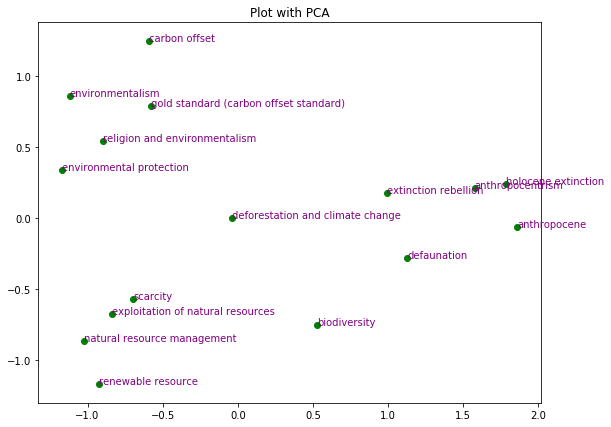

In [33]:
plt.figure(figsize=(9, 7))

plt.scatter(output_2d[:, 0], output_2d[:, 1], color='g')
for i,  sequence in enumerate(sequence_set):
  plt.annotate(sequence, xy=(output_2d[i, 0], output_2d[i, 1]), color='purple')
  plt.title('Plot with PCA')
        
plt.show()

### Replace PCA with t-SNE

Wondering whether there will be any structure difference.

In [34]:
from sklearn.manifold import TSNE

output_2d = TSNE(n_components=2).fit_transform(X)
output_2d

array([[-121.50858 , -138.59216 ],
       [  94.26443 ,  172.90782 ],
       [ -27.715925,  184.72836 ],
       [ -16.834784, -191.83905 ],
       [-114.79316 ,  -23.54879 ],
       [ 165.57234 ,  -54.777496],
       [  66.36455 ,  -16.445017],
       [-147.95229 ,  164.71706 ],
       [ 144.23003 ,   62.776688],
       [ -24.681862,    9.864247],
       [ -23.938444,  -85.10334 ],
       [  77.745804, -127.31301 ],
       [-193.26569 ,   55.10619 ],
       [ -81.7816  ,   84.58692 ],
       [  31.064302,   88.21838 ],
       [-213.42982 ,  -63.981052]], dtype=float32)

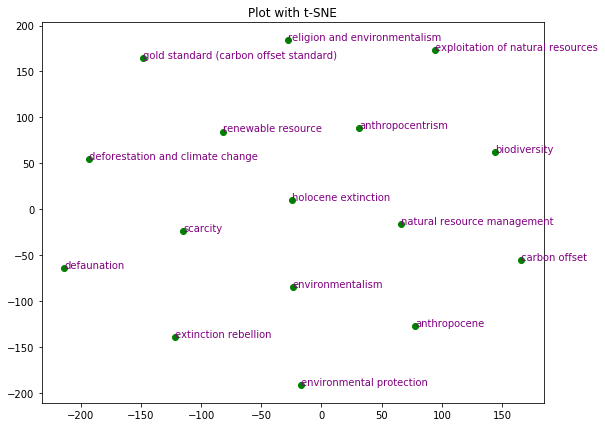

In [35]:
plt.figure(figsize=(9, 7))

plt.scatter(output_2d[:, 0], output_2d[:, 1], color='g')
for i,  sequence in enumerate(sequence_set):
  plt.annotate(sequence, xy=(output_2d[i, 0], output_2d[i, 1]), color='purple')
  plt.title('Plot with t-SNE')
        
plt.show()